<h2> Nauczanie maszynowe/Ćwiczenia6

<h3> Segmentacja

Zbiory danych:
- https://groups.csail.mit.edu/vision/datasets/ADE20K/
- https://www.cityscapes-dataset.com/
- https://cocodataset.org/#home

To się może przydać:

https://www.cellpose.org/dataset

https://www.kaggle.com/competitions/data-science-bowl-2018/data

https://www.robots.ox.ac.uk/~vgg/data/pets/

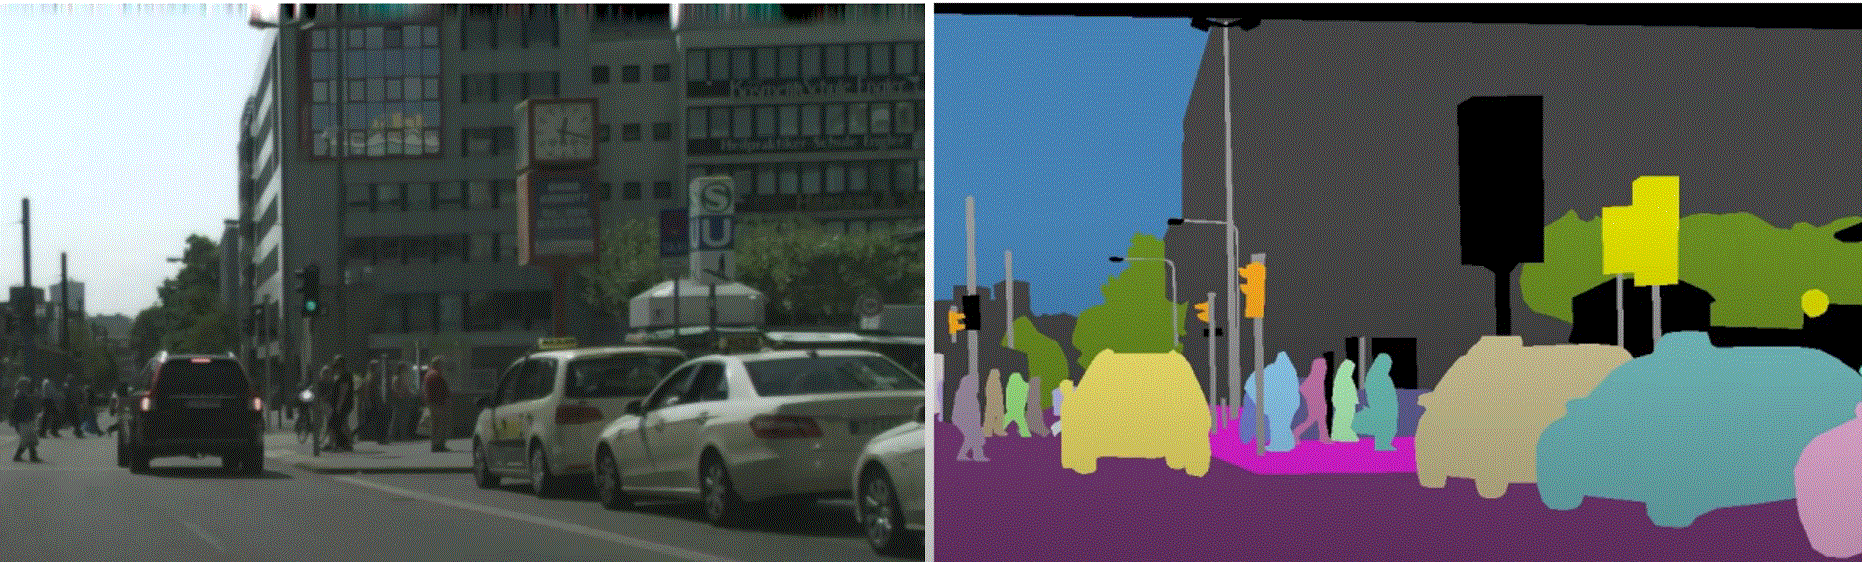

In [26]:
from IPython import display
display.Image("seg.gif", width="900", height="200")

Lewandowska, Emilia, Daniel Węsierski, Magdalena Mazur-Milecka, Joanna Liss, and Anna Jezierska. "Ensembling noisy segmentation masks of blurred sperm images." Computers in Biology and Medicine (2023): 107520.

Zadanie do implementacji funkcji kosztu Dice loss, Tversky Loss, Focal Tversky Loss oraz Hybrid Loss

<h4> Zadanie1: Poszukaj baz danych obrazów do segmentacji. Zbuduj model oparty o architekturę U-Net (swobodnie rozbuduj model z ćwiczeń), wydziel zbiór treningowy/walidacyjny/testowy. Potestuj różne hiperparametry.

In [1]:
import os
from PIL import Image
import torch
from torchvision import transforms

# Ścieżki do folderów
img_dir = 'SegSperm/train/images'
mask_dir = 'SegSperm/train/GT1_full'

# Transformacje — zamiana na tensory i ewentualna normalizacja
img_transform = transforms.Compose([
    transforms.ToTensor(),  # skala 0-1, kształt (C, H, W)
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # opcjonalnie
])

mask_transform = transforms.Compose([
    transforms.ToTensor()  # zamieni maskę 0/255 → 0.0/1.0
])

# Wczytanie wszystkich plików
image_files = sorted(os.listdir(img_dir))
mask_files = sorted(os.listdir(mask_dir))

images = []
masks = []

for img_name, mask_name in zip(image_files, mask_files):
    # Otwórz obrazy i maski
    img_path = os.path.join(img_dir, img_name)
    mask_path = os.path.join(mask_dir, mask_name)
    
    image = Image.open(img_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')  # maska w odcieniach szarości

    # Zastosuj transformacje
    image_tensor = img_transform(image)
    mask_tensor = mask_transform(mask)

    # Upewnij się, że maska jest binarna (0/1)
    mask_tensor = (mask_tensor > 0.5).float()

    images.append(image_tensor)
    masks.append(mask_tensor)

# Połącz wszystko w jeden batch
images = torch.stack(images)  # kształt: (N, 3, H, W)
masks = torch.stack(masks)    # kształt: (N, 1, H, W)

print(images.shape, masks.shape)
print(images[:2])  # przykładowe dane
print(masks[:2])

torch.Size([432, 3, 512, 512]) torch.Size([432, 1, 512, 512])
tensor([[[[-0.1765, -0.1765, -0.1843,  ..., -0.2863, -0.2784, -0.2784],
          [-0.1765, -0.1765, -0.1843,  ..., -0.2863, -0.2784, -0.2784],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          ...,
          [-0.1922, -0.1843, -0.1843,  ..., -0.1843, -0.1922, -0.2000],
          [-0.1843, -0.1843, -0.1922,  ..., -0.1765, -0.1922, -0.2000],
          [-0.1922, -0.1843, -0.1843,  ..., -0.1765, -0.1922, -0.2000]],

         [[-0.1765, -0.1765, -0.1843,  ..., -0.2863, -0.2784, -0.2784],
          [-0.1765, -0.1765, -0.1843,  ..., -0.2863, -0.2784, -0.2784],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          ...,
          [-0.1922, -0.1843, -0.1843,  ..., -0.1843, -0.1922, -0.2000],
          [-0.1843, -0.1843, -0.1922,  ..., -0.1765, -0.1922, -0.2000],
          [-0.1922, -0.1843, -0.1843,  ..., -0.1765, -0.1922, -0.2000]],

         [[-0.1765, -0.1765, -0.1843,  .

In [3]:
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim

In [4]:
data, target = images, masks

train_dataset = TensorDataset(data, target) #łączy dane i targety w jeden zbior danych
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [7]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Enkoder
        self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.enc_conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2) 

        # Dekoder
        self.dec_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec_conv2 = nn.ConvTranspose2d(64, 16, kernel_size=2, stride=2)  
        self.dec_conv3 = nn.Conv2d(32, 1, kernel_size=1)  

    def forward(self, x):
        x1 = F.relu(self.enc_conv1(x))      
        x1_pooled = self.pool(x1)
        
        x2 = F.relu(self.enc_conv2(x1_pooled))  
        x2_pooled = self.pool(x2)
        
        x3 = F.relu(self.enc_conv3(x2_pooled))  

        
        x4 = F.relu(self.dec_conv1(x3))         
        x4 = torch.cat([x4, x2], dim=1)        
        
        x5 = F.relu(self.dec_conv2(x4))       
        x5 = torch.cat([x5, x1], dim=1)         

        output = torch.sigmoid(self.dec_conv3(x5)) 
        
        return output

    
model_u = UNet()
criterion = nn.BCELoss()  
optimizer = optim.Adam(model_u.parameters(), lr=0.001)

# Trenowanie modelu
num_epochs = 100

for epoch in range(num_epochs):
    for inputs, labels in train_loader:        
        outputs = model_u(inputs)
        labels = labels[:, :, :outputs.size(2), :outputs.size(3)]  # Dostosuj rozmiar etykiet
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 1 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/100, Loss: 0.05785713717341423
Epoch 2/100, Loss: 0.052098438143730164


KeyboardInterrupt: 

https://chatgpt.com/c/69091382-0a50-8329-b02b-ff77bc66f499

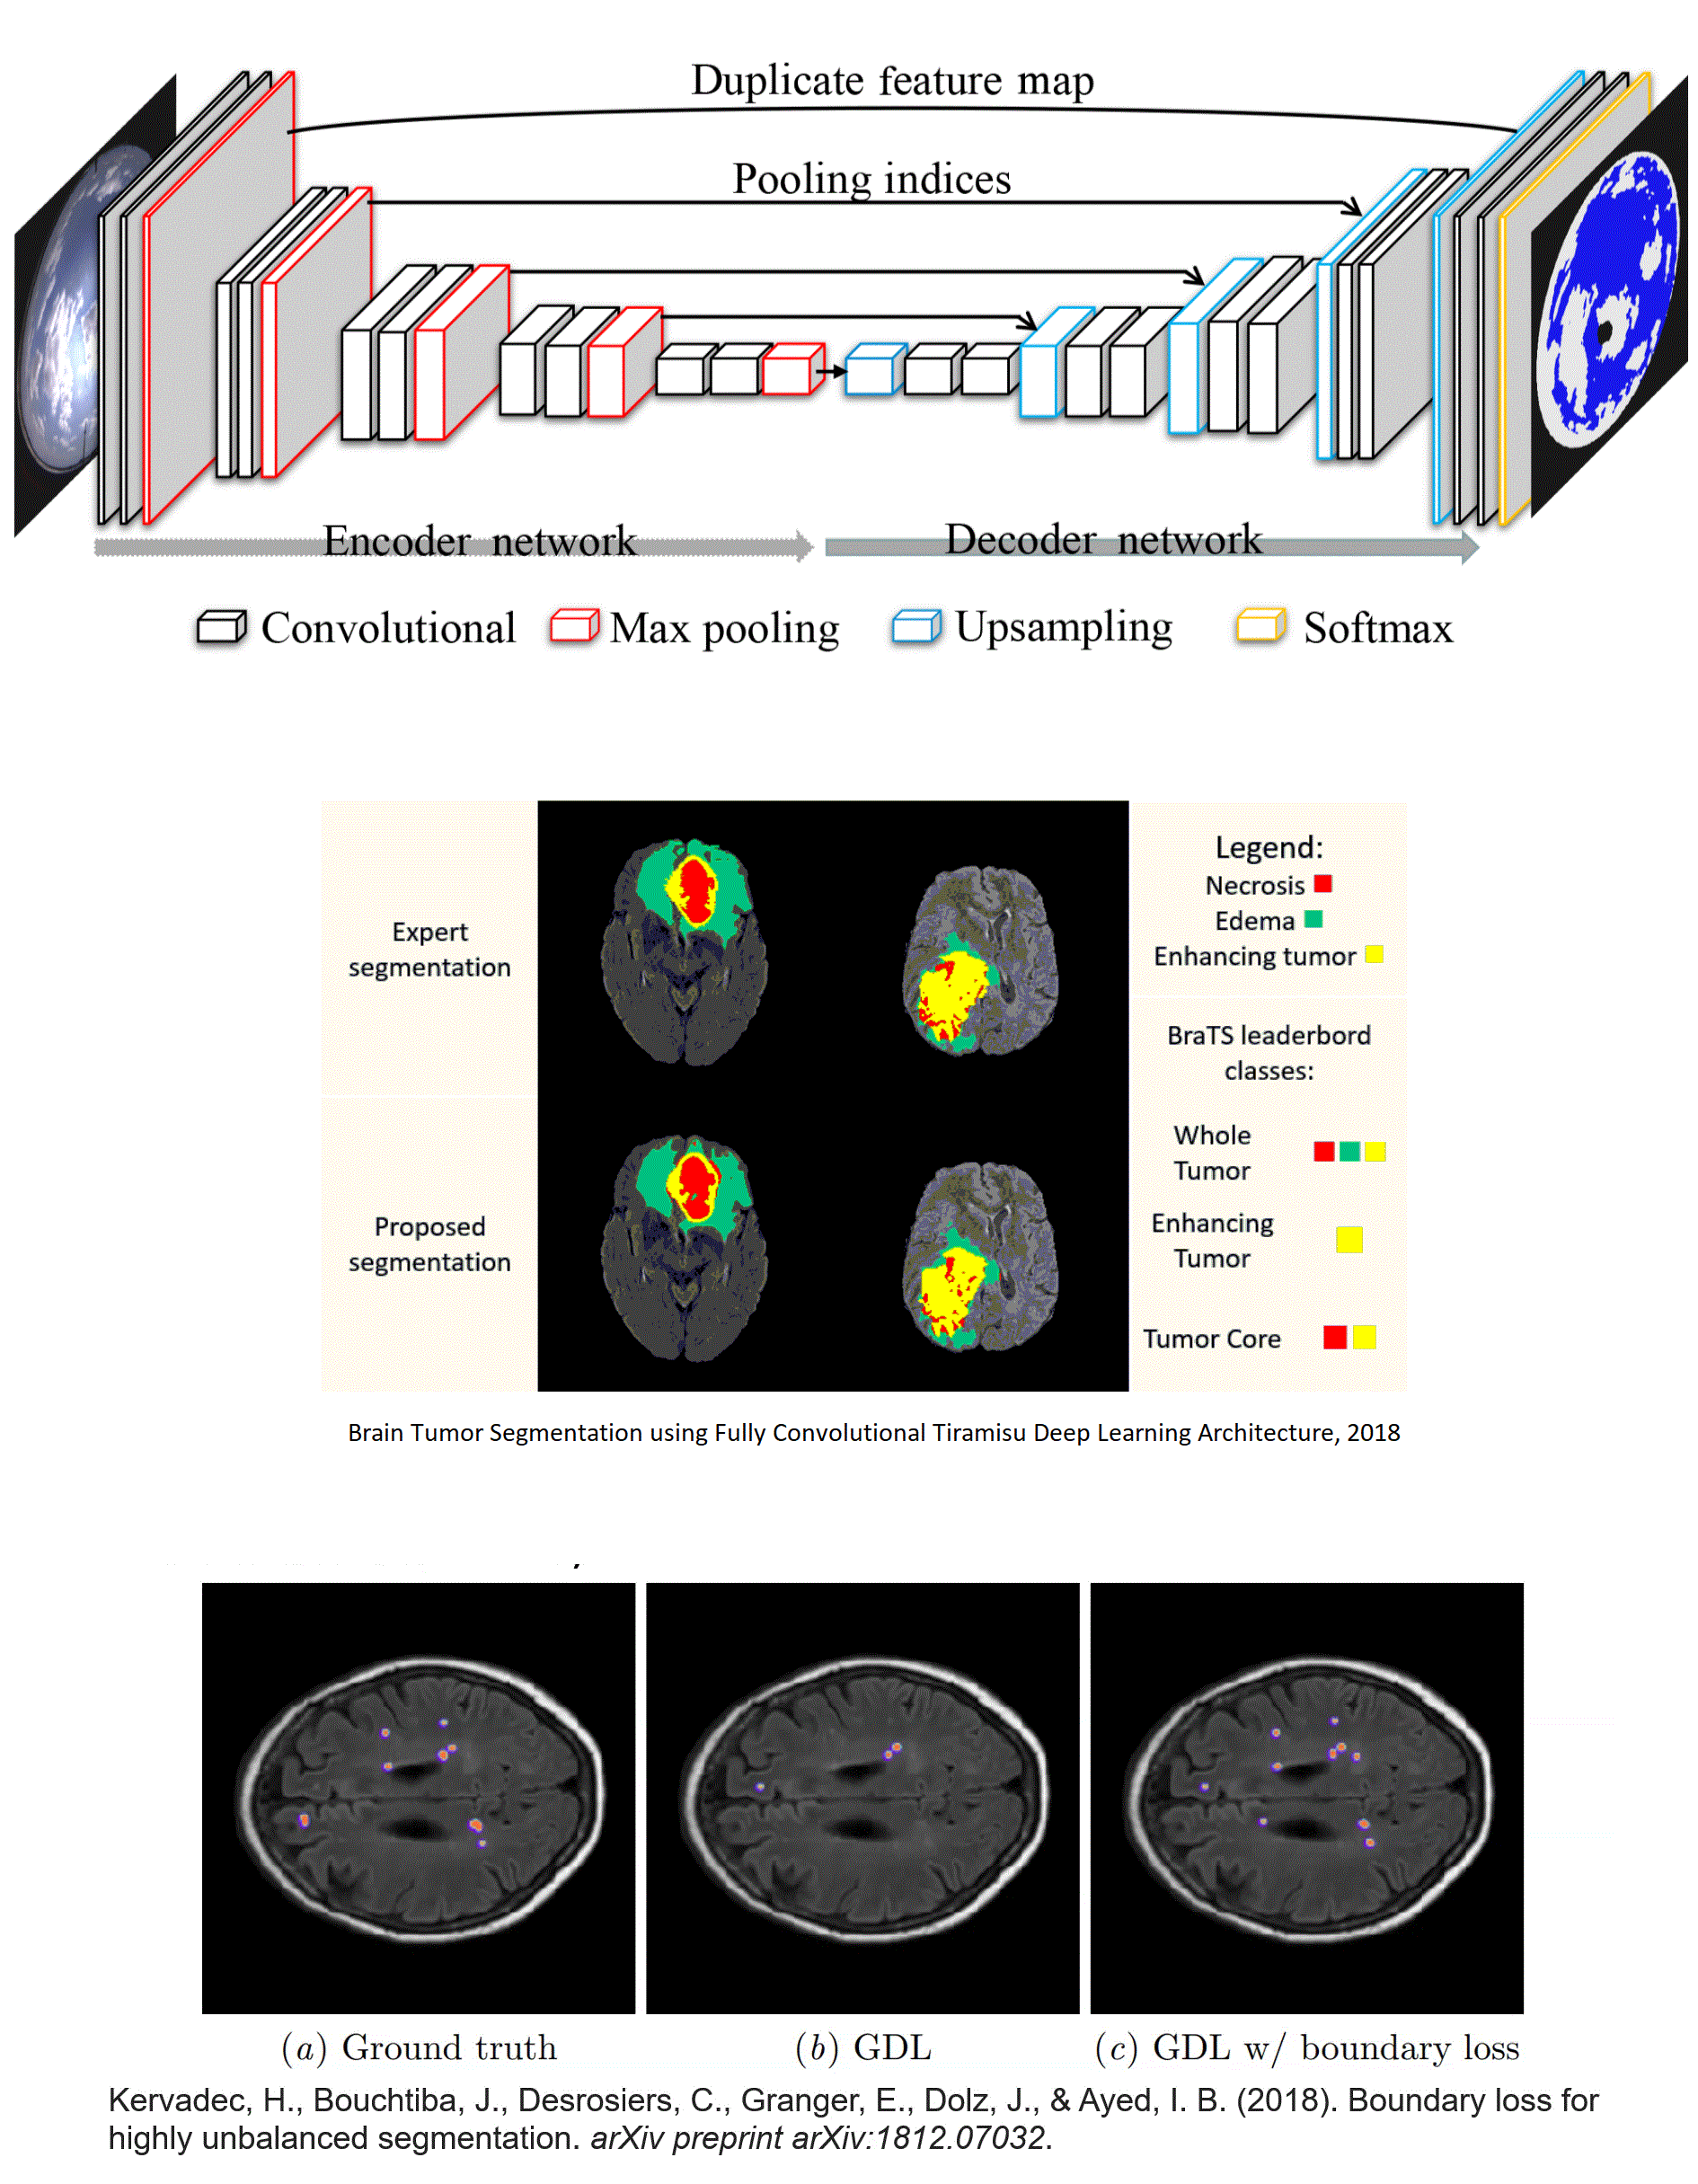

In [28]:
display.Image("seg2.png", width="900", height="200")

U-net:  https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

Zastosowania:
    
- Deep Neural Networks for Anatomical Brain Segmentation (https://openaccess.thecvf.com/content_cvpr_workshops_2015/W01/papers/Brebisson_Deep_Neural_Networks_2015_CVPR_paper.pdf)

- Using Deep Convolutional Neural Networks for Neonatal Brain Image Segmentation (https://www.frontiersin.org/articles/10.3389/fnins.2020.00207/full)

<h4> Autoencoder do rekonstrukcji obrazu

Uczymy się reprezentacji danych, w taki sposób aby móc odtworzyć dane wejściowe. 

Składa się z $\textbf{enkodera}$ - odwzorowuje zdjecia na wektory, oraz $\textbf{dekodera}$ - rekonstruuje zdjecia na podstawie wektorów

Autoenkoder rozumiemy jako sieć neuronową, która na wyjściu ma odtwarzać ten sam obiekt, który dostaje na wejściu. Zazwyczaj na autoenkoder patrzymy jako na połączenie dwóch modeli: enkodera $\mathcal{E}$ i dekodera $\mathcal{D}$. Interpretujemy działanie modelu w następujący sposób: enkoder kompresuje wejściowy przykład $x$ do wektora $y$, o którym myślimy jako o reprezentacji ukrytej. Dekoder na podstawie wektora $y$ produkuje $\hat{x}$, które ma aproksymować oryginalne wejście $x$. Tzn.:

$$
y = \mathcal{E} x \\
\hat{x} = \mathcal{D} y
$$

Funkcją kosztu w autoenkoderze będzie MSE pomiędzy wejściem a wyjściem:
$$
\mathcal{L}_{AE} =\frac{1}{n}\sum_i \|x_i-\mathcal{D}\mathcal{E} x_i\|_2^2,
$$
 

Enkoder i dekoder mogą być dowolnymi sieciami neuronowymi, najczęściej jednak dekoder składa się z tych samych transformacji co enkoder w odwrotnej kolejności. 

<h4> Pytanie: Jakie są wady stosowania funkcji kosztu MSE w przypadku segmentacji oraz autoenkodera?

## Wasserstein Autoencoder
Kolejnym zadaniem będzie zaimplementowanie Autoenkodera Wassersteina (Wasserstein Autoencoder) z kosztem Maximum Mean Discrepancy. Model ten jest identyczny pod względem architektury do zwyczajnego autoenkodera, ale dodatkowo wymusza żeby przykłady w przestrzeni ukrytej układały się w rozkład normalny. Dzięki temu po nauczeniu będziemy mogli generować nowe przykłady, samplując szum z rozkładu normalnego i przepuszczając go przez dekoder naszego autoenkodera.

W rezultacie WAE składa się ponownie z dwóch komponentów: Enkodera $\mathcal{E}$ oraz dekodera $\mathcal{D}$. Funkcja kosztu wygląda teraz następująco:

$$
\mathcal{L}_{WAE-MMD} =\frac{1}{n}\sum_i \|x_i-\mathcal{D}\mathcal{E} x_i\|^2+
C d^2_k((\mathcal{E} x_i),(z_j)),
$$

gdzie $z_j$ to sample wygenerowane z rozkładu normalnego $\mathcal{N}(0, I)$ a $C \in \mathcal{R}$ to hiperparametr ważący komponenty funkcji kosztu.

Pierwszy człon kosztu to koszt rekonstrukcji taki sam jak w przypadku zwyczajnego autoenkodera. Drugi człon funkcji kosztu to koszt MMD, zadany wzorem: 
$$
d^2_k((y_i),(z_j))=\frac{1}{n^2}\sum_{i,i'}k(y_i,y_{i'})+\frac{1}{n^2}\sum_{j,j'}k(z_j,z_{j'})-\frac{2}{n^2}\sum_{i,j}k(y_i,z_j),
$$
gdzie $k$ to wybrany przez nas kernel.

Koszt ten opisuje odległość pomiędzy reprezentacją ukrytą $y_i = \mathcal{E}x_i$ otrzymaną po przepuszczeniu przykładów treningowych przez enkoder a samplami $z_i$ wygenerowanymi z rozkładu normalnego $\mathcal{N}(0, I)$. Tym samym minimalizując ten koszt sprawimy że rozkład zadany przez enkoder będzie bardziej podobny do rozkładu normalnego, do którego chcemy się dopasować.

Na potrzeby zadania proszę skorzystać z kernela IMQ (inverse multi-quadratic) zadanego wzorem:
$$
k(y, z)=\frac{\sigma}{\sigma+\|y - z \|^2},
$$
gdzie $\sigma$ to hiperparametr, który trzeba znaleźć. 



<h4> Zadanie2 (2 pkt.)
    
W ramach zadania należy:
1. Zaimplementować architekturę autoenkodera Wassersteina (enkoder + dekoder). Jako że dataset FMNIST jest trudniejszy, to architektura też powinna być istotnie większa (np. 50 wymiarów przestrzeni ukrytej).
2. Zaimplementować elementy pętli uczenia WAE, w której minimalizujemy koszt $\mathcal{L}_{WAE-MMD}$.
3. Dostosować hiperparametry (learning rate, liczba epok, $C$, $\sigma$, etc.), tak żeby rekonstrukcja i generowane sample wyglądały na poziomie porównywalnym do tych pokazanych poniżej (albo lepiej). Zacznij od $C=1$, $\sigma = 2D$, gdzie $D$ to wymiar przestrzeni ukrytej.

W razie potrzeby można wspomóc się materiałami z wykładu, [oryginalną pracą o autoenkoderze Wassersteina](https://arxiv.org/abs/1711.01558) (interesuje nas zwłaszcza strona piąta, Algorytm 2 WAE-MMD) oraz [oficjalnie dostępną implementacją](https://github.com/tolstikhin/wae). 



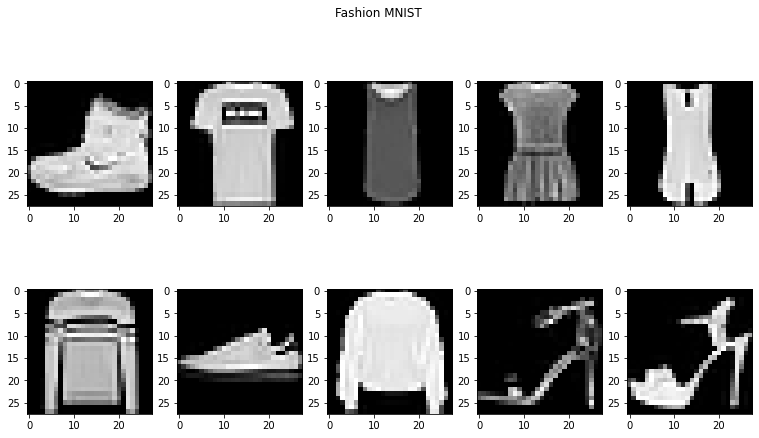

In [60]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Lambda, Compose


#dane FashionMNIST 
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])
train_data = FashionMNIST(root='.', 
                   train=True, 
                   transform=transforms,    
                   download=True)

batch_size = 256

# Data Loader
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 

_, axes = plt.subplots(2, 5, figsize=(13, 7))
for im, ax in zip(train_data.data[:10], axes.reshape(-1)):
    ax.imshow(im, cmap='gray')
plt.suptitle("Fashion MNIST")
plt.show()

In [ ]:
class WAEMMD(nn.Module):
    
    def __init__(self, latent_dim):
        
        super(WAEMMD, self).__init__()
        
        self.latent_dim = latent_dim
        
        D = latent_dim
        self.encoder = ???
        self.decoder = ???
       
    
    def decode(self, encoded):
        return self.decoder(encoded)
    
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        enc = self.encode(x)
        dec = self.decode(enc)
        return enc, dec
    
    def mmd_loss(self, y, sigma):
        
        ???

        return ???

Epoch: 0 | train loss: 0.06850


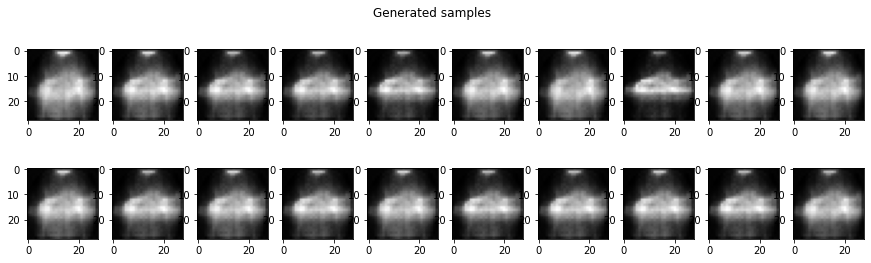

Epoch: 1 | train loss: 0.04854
Epoch: 2 | train loss: 0.04017


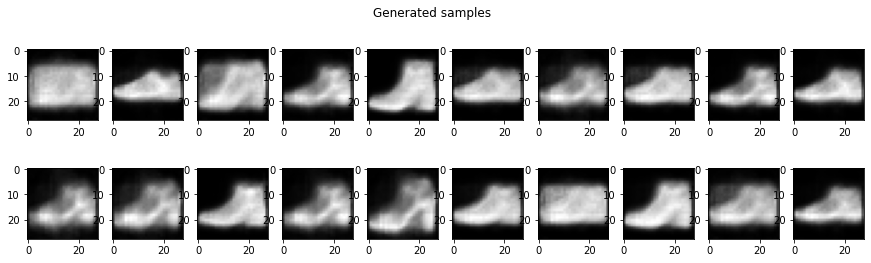

Epoch: 3 | train loss: 0.03622
Epoch: 4 | train loss: 0.03304


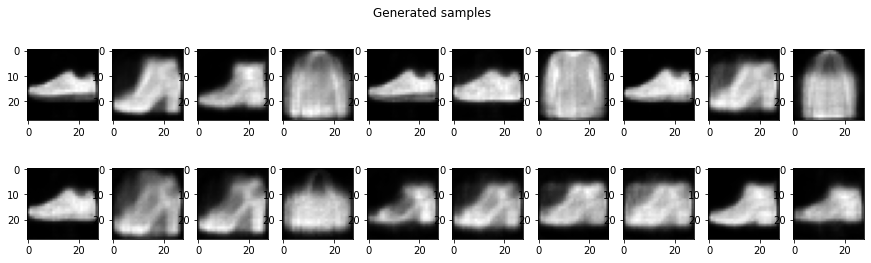

Epoch: 5 | train loss: 0.03036
Epoch: 6 | train loss: 0.02858


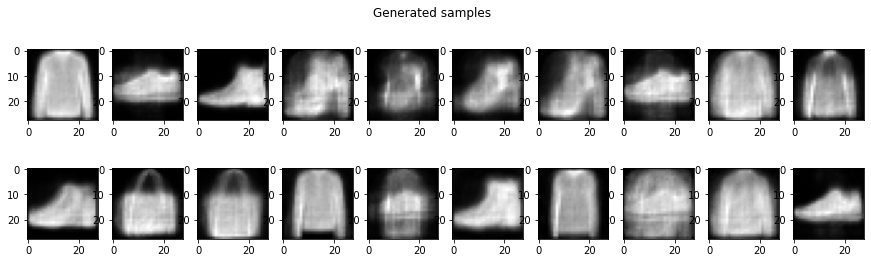

Epoch: 7 | train loss: 0.02735
Epoch: 8 | train loss: 0.02644


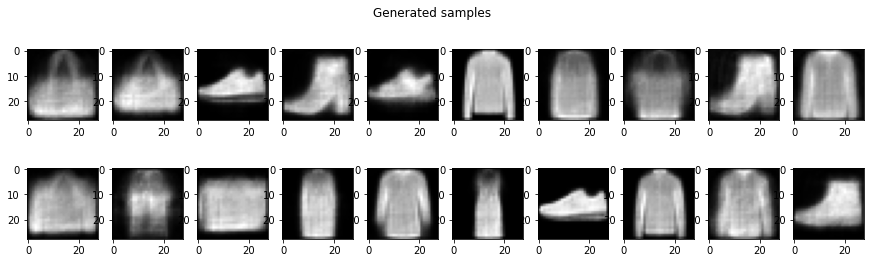

Epoch: 9 | train loss: 0.02548


In [65]:
def plot_samples(model):
    # generowanie wartosci z rozkladu normalnego i przerzucanie przez dekoder
    sampled_z = torch.randn(20, model.latent_dim)
    generated = model.decode(sampled_z)

    #graficzna prezentacja wynikow
    generated = generated.cpu().detach().numpy()
    _, axes = plt.subplots(2, 10, figsize=(15, 4))
    for gen_im, ax in zip(generated, axes.reshape(-1)):
        ax.imshow(gen_im.reshape(28, 28), cmap="gray")
    plt.suptitle("Generated samples")
    plt.show()

# Hiperparametry 
epochs = ???
LR = ???  # learning rate
latent_dim = ???
sigma = ???
C = ???


wae = WAEMMD(latent_dim)
optimizer = torch.optim.Adam(wae.parameters(), lr=LR)


rec_loss_fn = torch.nn.MSELoss() #klasysczna funkcja MSE

for epoch in range(epochs):
    epoch_losses = []
    for step, (x, y) in enumerate(train_loader):
        encoded, decoded = wae(x)

        rec_loss_val = ??? #nalezy wyznaczyc i zapisac do zmiennej wartosc funkcji kosztu MSE
        latent_loss_val = ??? #nalezy wyznaczyc i zapisac do zmiennej wartosc funkcji kosztu MSD
        loss_val = ??? #finalną wartosc funkcji kosztu nalezy wyznaczyc wg odpowiedniego wzoru


        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        epoch_losses += [loss_val.item()]

    print(f'Epoch: {epoch} | train loss: {np.mean(epoch_losses):.5f}')

    if epoch % 2 == 0:
        plot_samples(wae)


<h3> Uzupełnienie - wybrane metody w pytorch

In [19]:
x = torch.tensor([1,2,3])
y = torch.tensor([3.9,0.3,-1])

In [20]:
torch.round(y)

tensor([ 4.,  0., -1.])

In [21]:
torch.sign(y)

tensor([ 1.,  1., -1.])

In [22]:
torch.stack([x,y], dim=0)

tensor([[ 1.0000,  2.0000,  3.0000],
        [ 3.9000,  0.3000, -1.0000]])

In [35]:
x.sum()

tensor(6)

In [37]:
x.unsqueeze(0)

tensor([[1, 2, 3]])

In [38]:
x.unsqueeze(1)

tensor([[1],
        [2],
        [3]])

In [46]:
torch.randn(5, 2, 3)

tensor([[[ 2.3459,  0.0849,  0.9450],
         [ 1.0577,  0.3975,  0.1455]],

        [[-0.3189,  1.0778,  1.6130],
         [ 1.8797,  2.1912, -0.2578]],

        [[ 0.3873,  0.3091,  0.0091],
         [-1.7529, -0.3125, -1.9889]],

        [[-0.2904,  0.3809, -0.1004],
         [-1.4806, -1.0010,  0.4098]],

        [[ 0.2042, -0.3511, -0.4522],
         [-1.5111, -3.2540, -1.0257]]])

In [56]:
torch.randn(5, 2, 3).square()

tensor([[[6.4578e+00, 9.9095e-01, 2.3188e-01],
         [4.2904e-02, 2.5379e-01, 1.5250e-01]],

        [[1.2417e+00, 2.1084e-02, 1.5348e+00],
         [1.8707e+00, 2.5753e-01, 1.7870e-01]],

        [[4.5567e+00, 3.6542e-01, 2.4716e+00],
         [4.7914e-02, 2.8841e-01, 1.5850e+00]],

        [[5.1327e-04, 2.6949e-03, 6.5686e-01],
         [1.0193e-01, 1.6451e+00, 3.4382e+00]],

        [[2.8553e+00, 5.9721e-02, 4.2214e-02],
         [1.7690e+00, 1.3222e+00, 4.8846e-02]]])

In [57]:
torch.randn(5, 2, 3).sum(-1)

tensor([[-0.1526, -2.0733],
        [-2.9071, -2.4371],
        [-1.5335, -0.2538],
        [ 0.6903, -1.1538],
        [ 1.5597, -0.7045]])